<h1><center><b> Machine Learning </b></center></h1>
<h2><center><i>Course Work (coding part)</i></center></h2>

<center>Candidate no: 246743</center>

# TASK

The data come from photos, and your task is to come up with a machine learning method for classifying the photos according to whether or not they are 'memorable'. The data you are given for each photo consists of 4608 features. 4096 of these were extracted from a deep Convolutional Neural Network (CNN) [1], and the remaining 512 are gist features [2]. (You are given all these features as a 1-dimensional array, so you will not be performing any feature extraction on raw images.)

<br/>

There are two files of training data. The first contains 600 samples with all the data present. The second contains 2800 samples, which have some missing data, as indicated by a NaN (not a number). The training data have class labels, 1 for memorable, and 0 for not memorable. In addition, there is also a confidence label for each sample. The class labels were assigned based on decisions from 3 people viewing the photos. When they all agreed, the class label could be considered certain, and a confidence of 1 was written down. If they didn't all agree, then the classification decided on by the majority was assigned, but with a confidence of only 0.66.

<br/>

There is one file of test data, containing 2000 samples. You must obtain predictions for the class labels of these. (Note that, as with the second training set, the samples in the test data set contain missing features.)

<br/>

Your job is to obtain the best predictions you can, and to justify your methods. You should reason for which classifier or combination of classifiers you use, how you do model selection (training-validation split or cross validation), and how you handle the specific issues with these data (large number of features, missing data, the presence of confidence labels for the classes of the training data). We value creative approaches!

<br/>

You may make use of any classifier, such as: single-layer perceptron, multi-layer perceptron, SVM, random forest, logistic regression. You are not required to code classifiers from scratch, and you can use any machine learning toolbox you like, such as scikit-learn ( https://scikit-learn.org/stable/ (Links to an external site.) ).


# Import & Load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import normalize

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from numpy import mean
from numpy import std
import copy

In [ ]:
## Import Training Data


# IF USING GOOGLE COLAB: 
from google.colab import drive
drive.mount('/content/drive')

train_data1 = pd.read_csv('/content/drive/MyDrive/data-1/training1.csv')
train_data2 = pd.read_csv('/content/drive/MyDrive/data-1/training2.csv')
test_data = pd.read_csv('/content/drive/MyDrive/data-1/test.csv')

from google.colab import files


# # IF USING JUPYTER NOTEBOOK:
# train_data1 = pd.read_csv('./data-1/training1.csv')
# train_data2 = pd.read_csv('./data-1/training2.csv')
# test_data = pd.read_csv('./data-1/test.csv')

Mounted at /content/drive


# Pre-Processing

## split up train & val set

In [ ]:
# get 15% of train_data1 as validation set (90 rows)
val_1 = int(len(train_data1)*0.15)

# training set of 'train_data1', ndarray format
train_label1 = np.asarray(train_data1.iloc[val_1:,-2])
train_conf1 = np.asarray(train_data1.iloc[val_1:,-1])
train_x1 = np.asarray(train_data1.iloc[val_1:,:-2])
val_label1 = np.asarray(train_data1.iloc[:val_1,-2])
val_conf1 = np.asarray(train_data1.iloc[:val_1,-1])
val_x1 = np.asarray(train_data1.iloc[:val_1,:-2])


# get 15% of train_data2 as validation set (420 rows)
val_2 = int(len(train_data2)*0.15)

# training set of 'train_data2', ndarray format
train_label2 = np.asarray(train_data2.iloc[val_2:,-2])
train_conf2 = np.asarray(train_data2.iloc[val_2:,-1])
train_x2 = np.asarray(train_data2.iloc[val_2:,:-2])
val_label2 = np.asarray(train_data2.iloc[:val_2,-2])
val_conf2 = np.asarray(train_data2.iloc[:val_2,-1])
val_x2 = np.asarray(train_data2.iloc[:val_2,:-2])

## handling NaN

In [ ]:
# initialize a KNN imputer
imputer = KNNImputer(n_neighbors=1)

In [ ]:
# training set and val set of train_data2
train_x2 = imputer.fit_transform(train_x2)
val_x2 = imputer.fit_transform(val_x2)

# test data
test_data = imputer.fit_transform(test_data)

## normalisation

In [ ]:
# training data
train_x1 = normalize(train_x1, 'l2')
train_x2 = normalize(train_x2, 'l2')
# test data (4608 features)
test_data = normalize(test_data, 'l2')

In [ ]:
# validation data
val_x1 = normalize(val_x1, 'l2')
val_x2 = normalize(val_x2, 'l2')

## combine dataset


In [ ]:
# combine training set
train_x = np.concatenate((train_x1, train_x2))
train_label = np.concatenate((train_label1, train_label2))
train_conf = np.concatenate((train_conf1, train_conf2))

# combine validation set
val_x = np.concatenate((val_x1, val_x2))
val_label = np.concatenate((val_label1, val_label2))
val_conf = np.concatenate((val_conf1, val_conf2))

# Datasets

## split CNN & gist features
split the training set into CNN and gist, in order to figure out how will they work rescpectively

In [ ]:
sample_x_CNN = train_x[:,:4096]
sample_x_gist = train_x[:,4096:]

## dataset of all confidence 1
only extract the rows that have confidence=1, and see how it works

In [ ]:
extra_x = copy.deepcopy(train_x)
extra_label = copy.deepcopy(train_label)
extra_conf = copy.deepcopy(train_conf)

In [ ]:
idxs = []
for idx in range(len(extra_conf)):
  if extra_conf[idx] != 1:
    idxs.append(idx)

counter = 0
for i in idxs:
  extra_x = np.delete(extra_x, i-counter, axis=0)
  extra_label = np.delete(extra_label, i-counter, axis=0)
  extra_conf = np.delete(extra_conf, i-counter, axis=0)
  counter += 1

# Training

## cross validation

### Logistic Regression

In [ ]:
# the normal training dataset (combined by train_data1 and train_data2)
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=100)
log_clf = LogisticRegressionCV(solver='liblinear', max_iter=1000, random_state=42)
score = cross_val_score(log_clf, train_x, train_label, cv=rskf, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.754) total time=  36.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.3s remaining:    0.0s


[CV] END ................................ score: (test=0.740) total time=  35.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.744) total time=  35.6s
[CV] END ................................ score: (test=0.732) total time=  35.5s
[CV] END ................................ score: (test=0.754) total time=  36.5s
[CV] END ................................ score: (test=0.766) total time=  36.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.6min finished


0.7484447015363757

In [ ]:
# CNN features only
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=100)
log_clf = LogisticRegressionCV(solver='liblinear', max_iter=1000, random_state=42)
score = cross_val_score(log_clf, sample_x_CNN, train_label, cv=rskf, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.754) total time=  23.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s remaining:    0.0s


[CV] END ................................ score: (test=0.740) total time=  22.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.7s remaining:    0.0s


[CV] END ................................ score: (test=0.744) total time=  23.1s
[CV] END ................................ score: (test=0.732) total time=  23.5s
[CV] END ................................ score: (test=0.754) total time=  22.7s
[CV] END ................................ score: (test=0.766) total time=  22.5s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.3min finished


0.7484447015363757

In [ ]:
# gist features only
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=100)
log_clf = LogisticRegressionCV(solver='liblinear', max_iter=1000, random_state=42)
score = cross_val_score(log_clf, sample_x_gist, train_label, cv=rskf, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.668) total time=   2.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] END ................................ score: (test=0.664) total time=   2.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV] END ................................ score: (test=0.678) total time=   2.7s
[CV] END ................................ score: (test=0.663) total time=   2.7s
[CV] END ................................ score: (test=0.690) total time=   2.7s
[CV] END ................................ score: (test=0.694) total time=   2.7s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   16.4s finished


0.6759551898817807

In [ ]:
# confidence=1 only
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=100)
log_clf = LogisticRegressionCV(solver='liblinear', max_iter=1000, random_state=42)
score = cross_val_score(log_clf, extra_x, extra_label, cv=rskf, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.821) total time=   5.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV] END ................................ score: (test=0.781) total time=   5.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s


[CV] END ................................ score: (test=0.777) total time=   5.0s
[CV] END ................................ score: (test=0.810) total time=   5.2s
[CV] END ................................ score: (test=0.749) total time=   5.2s
[CV] END ................................ score: (test=0.757) total time=   5.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.0s finished


0.7824495668121166

### SVC & Linear SVC
train on the normal training dataset (combined by train_data1 and train_data2)

In [ ]:
# SVC
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=100)
svc_clf = SVC(random_state=40, tol=55)
score = cross_val_score(svc_clf, train_x, train_label, cv=rskf, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.463) total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ................................ score: (test=0.463) total time=   0.2s
[CV] END ................................ score: (test=0.463) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.463) total time=   0.2s
[CV] END ................................ score: (test=0.463) total time=   0.2s
[CV] END ................................ score: (test=0.463) total time=   0.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.0s finished


0.4629758893729112

In [ ]:
# Linear SVC
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=100)
svc_clf = LinearSVC(random_state=40, tol=55)
score = cross_val_score(svc_clf, train_x, train_label, cv=rskf, verbose=3)
score.mean()

[CV] END ................................ score: (test=0.737) total time=   0.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=0.724) total time=   0.2s
[CV] END ................................ score: (test=0.700) total time=   0.2s
[CV] END ................................ score: (test=0.698) total time=   0.2s
[CV] END ................................ score: (test=0.659) total time=   0.2s
[CV] END ................................ score: (test=0.660) total time=   0.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s finished


0.6963595279849595

## prediction

### Logistic Regression

In [ ]:
# train_x
pca = PCA()
scaler = StandardScaler()
logistic = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60, 75, 90, 105],
    "logistic__C": np.logspace(-4, 4, 4),
}
search1 = GridSearchCV(pipe, param_grid, n_jobs=2)
search1.fit(train_x, train_label)
print("Best parameter (CV score=%0.3f):" % search1.best_score_)
print(search1.best_params_)

# make the prediction
log_pred = search1.predict(val_x)

Best parameter (CV score=0.758):
{'logistic__C': 21.54434690031882, 'pca__n_components': 45}


In [ ]:
# CNN only
pca = PCA()
scaler = StandardScaler()
logistic = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60, 75, 90, 105],
    "logistic__C": np.logspace(-4, 4, 4),
}
search2 = GridSearchCV(pipe, param_grid, n_jobs=2)
search2.fit(sample_x_CNN, train_label)
print("Best parameter (CV score=%0.3f):" % search2.best_score_)
print(search2.best_params_)

# make the prediction
CNN_pred = search2.predict(val_x[:,:4096])

Best parameter (CV score=0.753):
{'logistic__C': 10000.0, 'pca__n_components': 45}


In [ ]:
# gist only
pca = PCA()
scaler = StandardScaler()
logistic = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60, 75, 90, 105],
    "logistic__C": np.logspace(-4, 4, 4),
}
search3 = GridSearchCV(pipe, param_grid, n_jobs=2)
search3.fit(sample_x_gist, train_label)
print("Best parameter (CV score=%0.3f):" % search3.best_score_)
print(search3.best_params_)

# make the prediction
gist_pred = search3.predict(val_x[:,4096:])

Best parameter (CV score=0.693):
{'logistic__C': 21.54434690031882, 'pca__n_components': 60}


In [ ]:
# Confidence=1 only
pca = PCA()
scaler = StandardScaler()
logistic = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60, 75, 90, 105],
    "logistic__C": np.logspace(-4, 4, 4),
}
search4 = GridSearchCV(pipe, param_grid, n_jobs=2)
search4.fit(extra_x, extra_label)
print("Best parameter (CV score=%0.3f):" % search4.best_score_)
print(search4.best_params_)

# make the prediction
extra_log_pred = search4.predict(val_x)

Best parameter (CV score=0.794):
{'logistic__C': 10000.0, 'pca__n_components': 45}


### SVC & Linear SVC

In [ ]:
# SVC
scaler = StandardScaler()
svc = SVC(kernel='sigmoid', random_state=0, tol=5, decision_function_shape='ovo')

svc_clf = make_pipeline(scaler, svc)
svc_clf.fit(train_x, train_label)

# make the prediction
svc_pred = svc_clf.predict(val_x)

In [ ]:
# Linear SVC
scaler = StandardScaler()
lin_svc = LinearSVC(C=1.0, tol=5, max_iter=1000, penalty='l2', loss='squared_hinge', dual=True, multi_class='ovr', fit_intercept=True, intercept_scaling=1)

linsvc_clf = make_pipeline(scaler, svc)
linsvc_clf.fit(train_x, train_label)

# make the prediction
linsvc_pred = linsvc_clf.predict(val_x)

## accuracy

In [ ]:
def calc_accuracy(prediction, ground_true):
  rec = 0
  for i in range(len(prediction)):
    if prediction[i] == ground_true[i]:
      rec += 1
  acc = rec/len(ground_true)
  return acc

In [ ]:
log_accuracy = calc_accuracy(log_pred, val_label)*100
print('Acuracy of Logistic Regression (train_x) is ', log_accuracy, '%')

CNN_accuracy = calc_accuracy(CNN_pred, val_label)*100
print('Acuracy of Logistic Regression (CNN_x) is ', CNN_accuracy, '%')

gist_accuracy = calc_accuracy(gist_pred, val_label)*100
print('Acuracy of Logistic Regression (gist_x) is ', gist_accuracy, '%')

extra_accuracy = calc_accuracy(extra_log_pred, val_label)*100
print('Acuracy of Logistic Regression (data confidence=1 only) is ', extra_accuracy, '%')

svc_accuracy = calc_accuracy(svc_pred, val_label)*100
print('Acuracy of SVC (train_x) is ', svc_accuracy, '%')

linsvc_accuracy = calc_accuracy(linsvc_pred, val_label)*100
print('Acuracy of Linear SVC (train_x) is ', linsvc_accuracy, '%')

Acuracy of Logistic Regression (train_x) is  72.35294117647058 %
Acuracy of Logistic Regression (CNN_x) is  70.19607843137254 %
Acuracy of Logistic Regression (gist_x) is  64.70588235294117 %
Acuracy of Logistic Regression (data confidence=1 only) is  72.15686274509804 %
Acuracy of SVC (train_x) is  46.07843137254902 %
Acuracy of Linear SVC (train_x) is  46.07843137254902 %


In [ ]:
cr = classification_report(val_label, extra_log_pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74       275
         1.0       0.69      0.71      0.70       235

    accuracy                           0.72       510
   macro avg       0.72      0.72      0.72       510
weighted avg       0.72      0.72      0.72       510



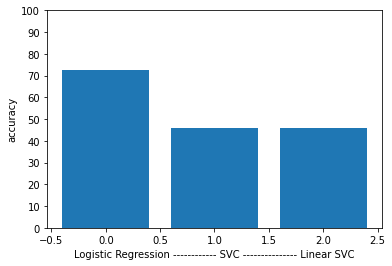

In [ ]:
# record = {'Logic Regression':log_accuracy, 'SVC':svc_accuracy, 'Linear SVC':linsvc_accuracy}
record = np.array([log_accuracy, svc_accuracy, linsvc_accuracy])
xaxis = np.arange(0, 3, 1)

plt.bar(xaxis, record)
plt.yticks(np.arange(0,110,10))
plt.xlabel('Logistic Regression ------------ SVC --------------- Linear SVC')
plt.ylabel('accuracy')
plt.show()

# Save Test Prediction
use google colab to download the prediction

In [ ]:
# use logistic regression model to predict the test data
result = search1.predict(test_data)
df = pd.DataFrame({'prediction':result.astype(int)})
df.to_csv('test_prediction.csv', encoding='utf-8-sig', index=False) 
files.download('test_prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>